In [1]:
# Import modules
import pandas as pd
import geopandas as gpd
import glob
import numpy as np
import mapclassify
import matplotlib.pyplot as plt

# Define relative path to the file
grid_fp = r'data/MetropAccess_YKR_grid_EurefFIN.shp'
roads_fp = r'data/roads.shp'
metro_fp = r'data/metro.shp'

# Read the data
grid = gpd.read_file(grid_fp)
roads = gpd.read_file(roads_fp)
metro = gpd.read_file(metro_fp)

In [2]:
# Check the data
print(grid)
print('\n')
print(roads)
print('\n')
print(metro)

              x          y   YKR_ID  \
0      381875.0  6697880.0  5785640   
1      382125.0  6697880.0  5785641   
2      382375.0  6697880.0  5785642   
3      382625.0  6697880.0  5785643   
4      381125.0  6697630.0  5787544   
...         ...        ...      ...   
13226  372875.0  6665630.0  6016698   
13227  373125.0  6665630.0  6016699   
13228  372375.0  6665380.0  6018252   
13229  372625.0  6665380.0  6018253   
13230  372875.0  6665380.0  6018254   

                                                geometry  
0      POLYGON ((382000.000 6697750.000, 381750.000 6...  
1      POLYGON ((382250.000 6697750.000, 382000.000 6...  
2      POLYGON ((382500.000 6697750.000, 382250.000 6...  
3      POLYGON ((382750.000 6697750.000, 382500.000 6...  
4      POLYGON ((381250.000 6697500.000, 381000.000 6...  
...                                                  ...  
13226  POLYGON ((373000.000 6665500.000, 372750.000 6...  
13227  POLYGON ((373250.000 6665500.000, 373000.000 6...  


In [3]:
# Check the crs of each layer
print(roads.crs)
print(metro.crs)
print(grid.crs)

epsg:2392
epsg:2392
epsg:3067


In [4]:
# Check CRS names
print("Roads crs:", roads.crs.name)
print("Metro crs:", metro.crs.name)
print("Grid crs: ",grid.crs.name)

Roads crs: KKJ / Finland zone 2
Metro crs: KKJ / Finland zone 2
Grid crs:  ETRS89 / TM35FIN(E,N)


In [5]:
# Reproject geometries to ETRS89 / TM35FIN based on the grid crs:
roads = roads.to_crs(crs=grid.crs)
metro = metro.to_crs(crs=grid.crs)

In [6]:
# Fetch the filepaths that contain information about the travel times to different shopping centers
filepaths = glob.glob(r'data/TravelTimes*.txt')

# Check how many filepaths there are
print("Number of travel time data files: ", len(filepaths))

Number of travel time data files:  7


In [7]:
# Repeat the analysis steps for each input file
for fp in filepaths:
    
    # Read the data into a DataFrame
    data = pd.read_csv(fp, sep=';')
    
    # Subset columns
    data = data[['from_id', 'pt_r_t']]
    
    # Rename the column 'from_id'
    data.rename(columns={'from_id': 'YKR_ID'}, inplace=True)
    
    # Split the input filepath
    split_fp = fp.split('_')
    
    # Obtain the shopping center name
    shopping_center_name_txt = split_fp[-1]
    shopping_center_name = shopping_center_name_txt[:-4]
    
    # Rename the column 'pt_r_t'
    data.rename(columns={'pt_r_t': 'pt_r_t_' + shopping_center_name}, inplace=True)
    
    # Make a table join between grid and data based on 'YKR_ID' column
    grid = grid.merge(data, on='YKR_ID', how='left')

In [8]:
#Check data
print(grid.head())

# Check that there are correct number of columns
assert len(grid.columns) >= 9, "There are some columns missing from the grid."

          x          y   YKR_ID  \
0  381875.0  6697880.0  5785640   
1  382125.0  6697880.0  5785641   
2  382375.0  6697880.0  5785642   
3  382625.0  6697880.0  5785643   
4  381125.0  6697630.0  5787544   

                                            geometry  pt_r_t_Myyrmanni  \
0  POLYGON ((382000.000 6697750.000, 381750.000 6...                90   
1  POLYGON ((382250.000 6697750.000, 382000.000 6...                93   
2  POLYGON ((382500.000 6697750.000, 382250.000 6...                95   
3  POLYGON ((382750.000 6697750.000, 382500.000 6...                99   
4  POLYGON ((381250.000 6697500.000, 381000.000 6...                83   

   pt_r_t_Itis  pt_r_t_Forum  pt_r_t_IsoOmena  pt_r_t_Jumbo  pt_r_t_Dixi  \
0          132           110              141           101          102   
1          135           113              143           108          109   
2          137           115              145           109          111   
3          141           119            

In [9]:
# Replace all rows containing no-data values with NaN
grid = grid.replace(-1, np.nan)

# Drop NoData values
grid.dropna(inplace=True)

# Check the data
grid

,x,y,YKR_ID,geometry,pt_r_t_Myyrmanni,pt_r_t_Itis,pt_r_t_Forum,pt_r_t_IsoOmena,pt_r_t_Jumbo,pt_r_t_Dixi,pt_r_t_Ruoholahti
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",90.0,132.0,110.0,141.0,101.0,102.0,118.0
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",93.0,135.0,113.0,143.0,108.0,109.0,121.0
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",95.0,137.0,115.0,145.0,109.0,111.0,123.0
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",99.0,141.0,119.0,149.0,114.0,115.0,127.0
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",83.0,125.0,103.0,134.0,98.0,99.0,111.0
...,...,...,...,...,...,...,...,...,...,...,...
13225,372625.0,6665630.0,6016697,"POLYGON ((372750.000 6665500.000, 372500.000 6...",97.0,81.0,54.0,40.0,111.0,81.0,50.0
13226,372875.0,6665630.0,6016698,"POLYGON ((373000.000 6665500.000, 372750.000 6...",95.0,79.0,52.0,38.0,109.0,79.0,48.0
13227,373125.0,6665630.0,6016699,"POLYGON ((373250.000 6665500.000, 373000.000 6...",97.0,81.0,54.0,40.0,110.0,81.0,50.0
13229,372625.0,6665380.0,6018253,"POLYGON ((372750.000 6665250.000, 372500.000 6...",100.0,84.0,57.0,43.0,114.0,84.0,53.0


In [10]:
# Create a new column for minimum travel time values 
grid['min_t'] = None

# Create a new column for the closest shopping center id values
grid['dominant_service'] = None

# Define the columns that will be used to calculate the shortest time travel
value_columns = ['pt_r_t_Jumbo', 'pt_r_t_Dixi', 'pt_r_t_Myyrmanni', 'pt_r_t_Itis', 'pt_r_t_Forum', 'pt_r_t_IsoOmena', 'pt_r_t_Ruoholahti']

# Iterate over the rows
for idx, row in grid.iterrows():
    
    # Calculate the minimum values of the above columns for each row 
    minimum_values = row[value_columns].min()
    
    # Find out which column contains the minimum value
    closest_center = row[value_columns].astype(float).idxmin(axis=value_columns, skipna=True)
    
    # Update the value of 'min_t' column with the calculated values
    grid.at[idx, 'min_t'] = minimum_values
    
    # Update the value of 'dominant_services' column with the calculated values
    grid.at[idx, 'dominant_service'] = closest_center

# Check the data
grid

,x,y,YKR_ID,geometry,pt_r_t_Myyrmanni,pt_r_t_Itis,pt_r_t_Forum,pt_r_t_IsoOmena,pt_r_t_Jumbo,pt_r_t_Dixi,pt_r_t_Ruoholahti,min_t,dominant_service
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",90.0,132.0,110.0,141.0,101.0,102.0,118.0,90,pt_r_t_Myyrmanni
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",93.0,135.0,113.0,143.0,108.0,109.0,121.0,93,pt_r_t_Myyrmanni
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",95.0,137.0,115.0,145.0,109.0,111.0,123.0,95,pt_r_t_Myyrmanni
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",99.0,141.0,119.0,149.0,114.0,115.0,127.0,99,pt_r_t_Myyrmanni
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",83.0,125.0,103.0,134.0,98.0,99.0,111.0,83,pt_r_t_Myyrmanni
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13225,372625.0,6665630.0,6016697,"POLYGON ((372750.000 6665500.000, 372500.000 6...",97.0,81.0,54.0,40.0,111.0,81.0,50.0,40,pt_r_t_IsoOmena
13226,372875.0,6665630.0,6016698,"POLYGON ((373000.000 6665500.000, 372750.000 6...",95.0,79.0,52.0,38.0,109.0,79.0,48.0,38,pt_r_t_IsoOmena
13227,373125.0,6665630.0,6016699,"POLYGON ((373250.000 6665500.000, 373000.000 6...",97.0,81.0,54.0,40.0,110.0,81.0,50.0,40,pt_r_t_IsoOmena
13229,372625.0,6665380.0,6018253,"POLYGON ((372750.000 6665250.000, 372500.000 6...",100.0,84.0,57.0,43.0,114.0,84.0,53.0,43,pt_r_t_IsoOmena


In [11]:
print(grid[['YKR_ID', 'min_t', 'dominant_service']].head())

    YKR_ID min_t  dominant_service
0  5785640    90  pt_r_t_Myyrmanni
1  5785641    93  pt_r_t_Myyrmanni
2  5785642    95  pt_r_t_Myyrmanni
3  5785643    99  pt_r_t_Myyrmanni
4  5787544    83  pt_r_t_Myyrmanni


In [12]:
print(grid[['YKR_ID', 'min_t', 'dominant_service']].tail())

        YKR_ID min_t dominant_service
13225  6016697    40  pt_r_t_IsoOmena
13226  6016698    38  pt_r_t_IsoOmena
13227  6016699    40  pt_r_t_IsoOmena
13229  6018253    43  pt_r_t_IsoOmena
13230  6018254    42  pt_r_t_IsoOmena


In [13]:
# Define output filepath
output_fp = 'Dominant_service_grid.shp'

# Save grid to file
grid.to_file(output_fp)

In [14]:
# Create a Quantiles classifier
classifier = mapclassify.Quantiles.make(k=9)

# Classify the data
grid['min_t_cl'] = grid[['min_t']].apply(classifier)

# Check the data
grid

,x,y,YKR_ID,geometry,pt_r_t_Myyrmanni,pt_r_t_Itis,pt_r_t_Forum,pt_r_t_IsoOmena,pt_r_t_Jumbo,pt_r_t_Dixi,pt_r_t_Ruoholahti,min_t,dominant_service,min_t_cl
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",90.0,132.0,110.0,141.0,101.0,102.0,118.0,90,pt_r_t_Myyrmanni,8
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",93.0,135.0,113.0,143.0,108.0,109.0,121.0,93,pt_r_t_Myyrmanni,8
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",95.0,137.0,115.0,145.0,109.0,111.0,123.0,95,pt_r_t_Myyrmanni,8
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",99.0,141.0,119.0,149.0,114.0,115.0,127.0,99,pt_r_t_Myyrmanni,8
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",83.0,125.0,103.0,134.0,98.0,99.0,111.0,83,pt_r_t_Myyrmanni,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13225,372625.0,6665630.0,6016697,"POLYGON ((372750.000 6665500.000, 372500.000 6...",97.0,81.0,54.0,40.0,111.0,81.0,50.0,40,pt_r_t_IsoOmena,5
13226,372875.0,6665630.0,6016698,"POLYGON ((373000.000 6665500.000, 372750.000 6...",95.0,79.0,52.0,38.0,109.0,79.0,48.0,38,pt_r_t_IsoOmena,5
13227,373125.0,6665630.0,6016699,"POLYGON ((373250.000 6665500.000, 373000.000 6...",97.0,81.0,54.0,40.0,110.0,81.0,50.0,40,pt_r_t_IsoOmena,5
13229,372625.0,6665380.0,6018253,"POLYGON ((372750.000 6665250.000, 372500.000 6...",100.0,84.0,57.0,43.0,114.0,84.0,53.0,43,pt_r_t_IsoOmena,5


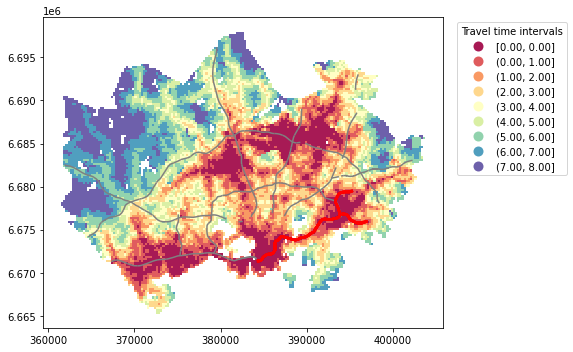

In [15]:
# Create a subplot
fig, ax = plt.subplots(figsize=(10,5))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(ax=ax, 
          column='min_t_cl',
          linewidth=0.03,
          cmap='Spectral',
          scheme='quantiles',
          k=9,
          alpha=0.9,
          legend=True,          
         )

# Add roads on top of the grid
roads.plot(ax=ax, color="grey", linewidth=1.5)

# Add metro on top of the previous map
metro.plot(ax=ax, color="red", linewidth=2.5)

# Re-position the legend and set a title
ax.get_legend().set_bbox_to_anchor((1.32,1))
ax.get_legend().set_title('Travel time intervals')

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
output_fp = "Travel_times_to_closest_shopping_center_static_map.png"
plt.savefig(output_fp, dpi=300)